In [ ]:
# first we define relevant directories
import sys
import os
import pickle
# project directory
project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# src directory (below)
src_dir = os.path.join(project_dir, 'src')
sys.path.insert(0, src_dir)
# get the tutorials dir
notebooks_dir = os.path.join(project_dir, 'notebooks')
dataset_dir = os.path.join(project_dir, "dataset")
print("dataset_dir: ", dataset_dir)
print("project_dir: ", project_dir)
print("notebooks_dir: ", notebooks_dir)

In [ ]:
from explore_hcupdata import *
from utilities import create_directory, ReaderWriter

In [ ]:
# load the NRD_Core dataset
nrd_core = load_nrd('Core', dataset_dir)
target_dir = create_directory('missing_analysis', project_dir)
report_missing(nrd_core, os.path.join(target_dir, 'check_missing_report_before.txt'))

In [ ]:
# fill missing data
fill_missing(nrd_core)

In [ ]:
# check again the status of missing -- sanity check
target_dir = create_directory('missing_analysis', project_dir)
report_missing(nrd_core, os.path.join(target_dir, 'check_missing_report_after.txt'))

In [ ]:
# pickle the cleaned/updated NRD_CORE
nrd_core.to_pickle(os.path.join(dataset_dir, 'NRD_CORE_2013_cleaned.pkl'))
del target_dir

### Cleaning/processing dataset to obtain target population

In [ ]:
def get_valid_visitlinks(df):
    primary_cond = df['dxccs1'] == 108 # congestive heart failure primary diagnosis
    age_cond = df['age'] >= 18
    visitlinks_A = set(df.loc[(primary_cond & age_cond), 'nrd_visitlink'].unique().tolist())

    # create a pseudo discharge date if it is not there
    if('pseudoddate' not in df):
        print("creating pseudo discharge date")
        df['pseudoddate'] = df['nrd_daystoevent'] + df['los']

    # this condition will check simultaneously the nrd_daystoevent and los
    # check patients with invlaide discharge dates
    cond_pseudoddate = pd.isnull(df['pseudoddate'])
    visitlinks_B = set(df.loc[(cond_pseudoddate), 'nrd_visitlink'].unique().tolist())

    # visitlinks of patients that are valid
    visitlinks_C = visitlinks_A - visitlinks_B
    return(visitlinks_C)


In [ ]:
valid_visitlinks = list(get_valid_visitlinks(nrd_core))
sample_nrd = nrd_core.loc[nrd_core['nrd_visitlink'].isin(valid_visitlinks)].copy()
sample_nrd.sort_values(by=['nrd_visitlink', 'pseudoddate'], inplace=True)
# target cols to show for now
show_cols = ['nrd_visitlink', 'age', 'nrd_daystoevent','los','pseudoddate', 'dxccs1', 'dxccs2', 'dmonth']
del valid_visitlinks

In [ ]:
# compute the number of days to readmission
def compute_readmit(gdf):
    res = gdf['nrd_daystoevent'].shift(-1) - gdf['pseudoddate']
    return(res)
s = sample_nrd.groupby(['nrd_visitlink']).apply(compute_readmit)
s = s.to_frame().reset_index()
s.set_index('level_1', inplace=True)
sample_nrd['readmit'] = s[0]
sample_nrd[show_cols+['readmit']].head()
# clean temp vars
del s

In [ ]:
# double check the delta_t denoted by readmit column if it is positive
outliers = sample_nrd.loc[sample_nrd['readmit']<0, show_cols + ['readmit']]
print(outliers)
print("-"*30)
# after inspection there are 32 outliers having future events in which 
# they are admitted before the discharge of previous events in their trajectory 
print("number of outliers ", len(outliers))
print()
# explore why this argument is valid by inspecting their full trajectory -- using 5 of these outliers as an example
outliers_vstlink = outliers['nrd_visitlink']
print(sample_nrd.loc[sample_nrd['nrd_visitlink'].isin(outliers_vstlink[:5]), show_cols + ['readmit']])
print()
# drop these outliers as they have inconsistent trajectory
outliers_indx = sample_nrd.loc[sample_nrd['nrd_visitlink'].isin(outliers_vstlink)].index
print("number of events correpsonding to outlier patients: ", len(outliers_indx))
sample_nrd.drop(outliers_indx, axis=0, inplace=True)
# clean temp vars
del outliers, outliers_vstlink, outliers_indx

In [ ]:
def check_age(gdf):
    age_diff = gdf['age'].shift(-1) - gdf['age']
    age_diff_sum = age_diff.sum()
    # given it is one-year data, the difference in age should be at most 1
    flag = age_diff_sum >= 0 and age_diff_sum <=1 
    return(not flag)
s = sample_nrd.groupby(['nrd_visitlink']).apply(check_age)

# check outliers due to age inconsistencies
ageissues_vstlink = s[s==True].index.tolist()
print("patients visitlink with age issues:\n", ageissues_vstlink)
print(sample_nrd.loc[sample_nrd['nrd_visitlink'].isin(ageissues_vstlink), show_cols + ['readmit']])
# drop age outlier patients
ageissues_indx = sample_nrd.loc[sample_nrd['nrd_visitlink'].isin(ageissues_vstlink)].index
sample_nrd.drop(ageissues_indx, axis=0, inplace=True)
# sanity check if patients with inconsistent age are still there
print(sample_nrd.loc[sample_nrd['nrd_visitlink'].isin(ageissues_vstlink), show_cols + ['readmit']])
del s, ageissues_vstlink, ageissues_indx

In [ ]:
def check_gender(gdf):
    gender_diff = gdf['female'].shift(-1) - gdf['female']
    gender_diff_sum = gender_diff.sum()
    flag = gender_diff_sum == 0 # consistent gender coding
    return(not flag)
s = sample_nrd.groupby(['nrd_visitlink']).apply(check_gender)

# check outliers due to gender inconsistencies
genderissues_vstlink = s[s==True].index.tolist()
print("patients visitlink with inconsistent gender coding:\n", genderissues_vstlink)
print(sample_nrd.loc[sample_nrd['nrd_visitlink'].isin(genderissues_vstlink), show_cols + ['readmit']])
# drop 
genderissues_indx = sample_nrd.loc[sample_nrd['nrd_visitlink'].isin(genderissues_vstlink)].index
sample_nrd.drop(genderissues_indx, axis=0, inplace=True)
# sanity check
print(sample_nrd.loc[sample_nrd['nrd_visitlink'].isin(genderissues_vstlink), show_cols + ['readmit']])
del s, genderissues_vstlink, genderissues_indx

In [ ]:
# create col for index event (i.e. when it the primary diagnosis of the event is congestive heart failure)
sample_nrd['index_event'] = 0
sample_nrd.loc[sample_nrd['dxccs1'] == 108, 'index_event'] = 1
# create col for 30 days all cause readmission after index event (i.e. target outcome variable)
sample_nrd['allcause_readmit'] = 0
sample_nrd.loc[((sample_nrd['readmit'] <= 30) & (sample_nrd['index_event'] == 1)), 'allcause_readmit'] = 1

In [ ]:
sample_nrd['rindx'] = sample_nrd.index # preserve original index in a new column
# check died events (if existing) should be the last events
diedevent_indx = sample_nrd.loc[sample_nrd['died'] == 1].index
levent_indx = sample_nrd.groupby(['nrd_visitlink']).nth(-1)['rindx']
# it is confirmed that registered died events are last events
print(diedevent_indx.shape)
print(levent_indx.shape)
diff = set(diedevent_indx.tolist()) - set(levent_indx.tolist())
print(len(diff))
print(diff)
# remove died events from trajectory -- they are not counted as index events by definition
sample_nrd.drop(diedevent_indx, axis=0, inplace=True)
del diedevent_indx, levent_indx, diff

In [ ]:
# update column index
sample_nrd['rindx'] = sample_nrd.index
# get all events in December and drop them as we cannot establish for all patients the readmission outcome for events occuring in December
# we are considering all events from Jan to November which we can establish their readmission outcome
december_eventsdf = sample_nrd.loc[sample_nrd['dmonth'] == 12]
print(december_eventsdf[show_cols + ['readmit', 'allcause_readmit']])
december_eventsindx = december_eventsdf.index
sample_nrd.drop(december_eventsindx, axis=0, inplace=True)
print(sample_nrd.loc[sample_nrd['dmonth'] == 12]) # confirm deletion
del december_eventsdf, december_eventsindx

In [ ]:
# compute readmission: 30-day readmission/index events
num_hf_indxevents = sample_nrd['index_event'].sum()
# print("HF readmission rate: ", sample_nrd['hf_readmit'].sum()/num_hf_indxevents)
print("30-day all-cause readmission rate: ", sample_nrd['allcause_readmit'].sum()/num_hf_indxevents)
# pickle the dataset for now
sample_nrd.to_pickle(os.path.join(dataset_dir, 'workingsample_HF_v1.pkl'))
del num_hf_indxevents

In [ ]:
def filter_nonhf_patients(sample_nrd):
    """in-place drop of patients who do not have index events after processing"""
    cond = sample_nrd['dxccs1'] == 108
    hf_vstlinks = set(sample_nrd.loc[cond, 'nrd_visitlink'].unique())
    all_vstlinks = set(sample_nrd['nrd_visitlink'].unique())
    # patients who do not have index events 
    # (i.e. no heart failure events in their trajectory after the applied processing)
    diff = all_vstlinks - hf_vstlinks
    print("number of patients with no heart failure event in their trajectory: ", len(diff))
    print()
    sample_nrd.drop(sample_nrd.loc[sample_nrd['nrd_visitlink'].isin(diff)].index, axis=0, inplace=True)

In [ ]:
fsample = sample_nrd
# updated show columns
show_cols = ['nrd_visitlink', 'nrd_daystoevent','los','pseudoddate','dmonth', 'readmit', 'allcause_readmit', 'dxccs1', 'dxccs2']
filter_nonhf_patients(fsample)

In [ ]:
# keep trajectories until the last HF event (i.e. inclusive) in a specified month
# warning: this cell might take some time to compute ~20 mins
def keep_traj_uptoHF(sample_nrd):
    def _keep_traj_uptoHF(gdf):
        cond = (gdf['dxccs1'] == 108)
        l_indx = np.where(cond)[0][-1] # last index event index
        gdf_index = gdf.index # indices of all events for the current patient
        return(gdf.loc[gdf_index[:l_indx+1]])
    s = sample_nrd.groupby(['nrd_visitlink']).apply(_keep_traj_uptoHF)
    s.reset_index(level=0, drop=True, inplace=True)
    return(s)

def compute_readmission_rate(fsample):
    # explore the readmission outcome for different minimum number of event in trajectory
    patients_g = fsample.groupby(['nrd_visitlink'])
    gsizes = patients_g.size()
    seqlens = gsizes.value_counts().index.tolist()
    for i in seqlens:
        target_p = gsizes[gsizes >=i].index.tolist()
        num_patients = len(target_p)
        print("number of patients with number of events >= to {0}: {1}".format(i, num_patients))
        # compute readmission 
        tmp = fsample.loc[fsample['nrd_visitlink'].isin(target_p)]
        num_patients = tmp['nrd_visitlink'].unique().shape[0]
        print("total number of patients: ", num_patients)
        num_hf_indxevents = (tmp['dxccs1'] == 108).sum()
        print("number of index events: ", num_hf_indxevents)
        allevent_readmit = tmp['allcause_readmit'].sum()
        print("number of 30-day all-cause readmissions: ", allevent_readmit)
        print("30-day all-cause readmission: ", allevent_readmit/num_hf_indxevents)
        lastevent_readmit = tmp.groupby('nrd_visitlink')['allcause_readmit'].nth(-1).sum()
        print("last event readmission: ", lastevent_readmit/num_patients)        
        print("30-day all-cause readmission for all event except the last event: ", (allevent_readmit-lastevent_readmit)/(num_hf_indxevents-num_patients))
        print()

In [ ]:
def get_top_diagproc_df(fsample, code_label_df, colname, qthreshold):
    if(colname == 'dxccs'):
        total_cols = 25
        name = 'diagnosis'
    elif(colname == 'prccs'):
        total_cols = 15
        name = 'procedures'
    cols_name = ["{}{}".format(colname, i) for i in range(1,total_cols+1)]
    target_df = pd.melt(fsample[cols_name], value_vars=cols_name, var_name=colname+'_rank', value_name=colname+'_val')

    # target_diag = [108.0, 249.0, 131.0, 107.0, 106.0, 105.0, 157.0, 55.0]
    tmp = target_df[colname+'_val'].value_counts()
    top_categs_df = tmp[tmp > tmp.quantile(qthreshold)].dropna()
    print(top_categs_df.shape)
    print("number of {} in top {}%: {}".format(name, (1-qthreshold)*100, len(top_categs_df)))
    print("-"*50)
    fig, ax = plt.subplots(figsize=(16, 9))
    top_categs_df.plot(kind='bar') 
    # build a dataframe from top label categories series
    top_categs_df = top_categs_df.to_frame()
    top_categs_df.index = top_categs_df.index.astype('int')
    top_categs_df.reset_index(inplace=True)
    top_categs_df.columns = ['ccs_code', 'count']
    top_categs_df['ccs_code'] = top_categs_df['ccs_code'].astype('str')
    # merge to get the label of top diagnosis
    # the keys should have the same type
    top_categs_df = pd.merge(left=top_categs_df, right=code_label_df, how='left', on=['ccs_code'])
    return(top_categs_df)

In [ ]:
def make_onehot(fsample, targetcol_prefix, labelspace_lst, num_targetcols, prefix):
    z = pd.DataFrame()
    for i in range(1, num_targetcols+1):
        targetcol_name = '{}{}'.format(targetcol_prefix, i)
        flag= fsample[targetcol_name].isnull().any() # check if nan values are there
        fsample["$categ_col$"] = fsample[targetcol_name]
        # fsample["$categ_col$"] = fsample["$categ_col$"].astype('category',categories=labelspace_lst)
        fsample["$categ_col$"] = fsample["$categ_col$"].astype(CategoricalDtype(categories=labelspace_lst))
        onehot_df = pd.get_dummies(fsample["$categ_col$"],prefix='{}{}'.format(prefix, i), dummy_na=flag)
        z=pd.concat([z, onehot_df], axis=1)
    del fsample["$categ_col$"] # remove the temporary categorical variable
    return(z)

In [ ]:
# evaluate missingness in the first, second, and third diagnosis and procedures fields/cols
for colprefix in ('dxccs', 'prccs'):
    for i in range(1,4):
        num_null = fsample['{}{}'.format(colprefix, i)].isnull().sum()
        print("the % of missing values in {}{} is {}".format(colprefix, i, num_null/fsample.shape[0] * 100))
    del num_null

### Generate features/computed variables from diagnosis

In [ ]:
import matplotlib.pyplot as plt

(255,)
number of diagnosis in top 100.0%: 255
--------------------------------------------------


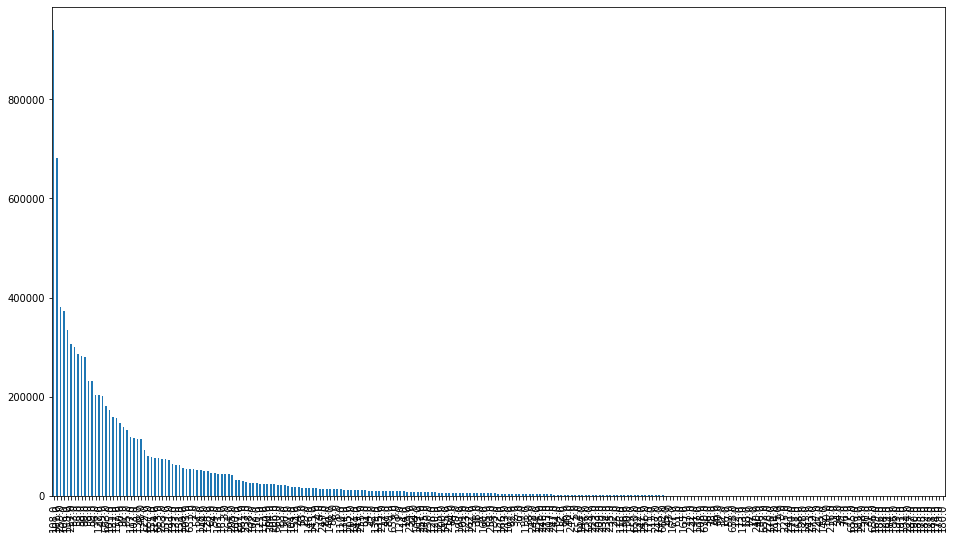

In [25]:
varcoding_dir = create_directory('variables', project_dir)
# diagnosis codes and associated labels
dxlabel = pd.read_csv(os.path.join(varcoding_dir, 'dxlabel 2015.csv'))
dxlabel.columns = ['ccs_code', 'ccs_label']
top_diagn_df = get_top_diagproc_df(fsample, dxlabel, 'dxccs', qthreshold=0.)

In [ ]:
# build one-hot encoding for first, second and third diagnosis
top_diagn_lst = top_diagn_df['ccs_code'].astype('float32').tolist()
onehot_df = make_onehot(fsample, "dxccs", top_diagn_lst, 3, "diagn")
# concat with fsample
fsample = pd.concat([fsample, onehot_df], axis=1)
del top_diagn_lst, onehot_df

In [ ]:
# compute new variables representing counts of every diagnosis category recorded in the 25 diagnosis columns
diagncols_name = ["dxccs{}".format(i) for i in range(1,26)]
# we need to cast the ccs_code to float before looking it up
top_diagn_lst = top_diagn_df['ccs_code'].astype('float32').tolist()
for top_diagn in top_diagn_lst:
    cond = fsample[diagncols_name] == top_diagn
    print(cond.head())
    fsample['diagncount_{}'.format(top_diagn)] = cond.sum(axis=1)
    print("-"*40)
del diagncols_name, top_diagn_lst, cond

### Generate features/computed variables from procedures

In [ ]:
# procedures codes with associated labels
prlabel = pd.read_csv(os.path.join(varcoding_dir, 'prlabel 2014 cleaned.csv'), sep=',')
prlabel.columns = ['ccs_code', 'ccs_label']
top_proc_df = get_top_diagproc_df(fsample, prlabel, 'prccs', qthreshold=0.)

In [ ]:
# build one-hot encoding for first, second and third procedures
top_proc_lst = top_proc_df['ccs_code'].astype('float32').tolist()
onehot_df = make_onehot(fsample, "prccs", top_proc_lst, 3, "proc")
# concat with fsample
fsample = pd.concat([fsample, onehot_df], axis=1)
del onehot_df, top_proc_lst

In [ ]:
# compute new variables representing counts of every procedure category recorded in the 15 procedures columns
proccols_name = ["prccs{}".format(i) for i in range(1,16)]
# produce the count using all the procedure categories
top_proc_lst = top_proc_df['ccs_code'].astype('float32').tolist()
for top_proccol in top_proc_lst:
    cond = fsample[proccols_name] == top_proccol
    print(cond.head())
    fsample['proccount_{}'.format(top_proccol)] = cond.sum(axis=1)
    print("-"*40)
del proccols_name, top_proc_lst, cond

In [ ]:
def create_deltat(gdf):
    gdf['deltat']=gdf['readmit'].shift(1)
    return(gdf)

In [ ]:
# create delta_t variable
fsample = fsample.groupby(['nrd_visitlink']).apply(create_deltat)
fsample['deltat'].fillna(0, inplace=True)
# reupdate the dtype of the variables
convert_dtypes(fsample)
# dump data checkpoint
ReaderWriter.dump_data(fsample, os.path.join(dataset_dir, 'workingsample_HF_ckpt1.pkl'))

In [ ]:
cols = ['e_ccs{}'.format(i) for i in range(1,5)] + ['ecode{}'.format(i) for i in range(1,5)]
check_percent_missing(fsample, cols)
del cols

In [ ]:
# build one-hot encoding for first ecodes
ecodes = set([])
for i in range(1, 5):
    ecodes = ecodes.union(set(fsample['e_ccs{}'.format(i)].value_counts().index))
ecodes_lst = list(ecodes)
onehot_df = make_onehot(fsample, "e_ccs", ecodes_lst, 1, "ecode")
fsample = pd.concat([fsample, onehot_df], axis=1)

# setup the ecode injuries code counts
for ecode_categ in ecodes_lst:
    cond = fsample[["e_ccs{}".format(i) for i in range(1, 5)]] == ecode_categ
    print(cond.head())
    fsample['ecodecount_{}'.format(ecode_categ)] = cond.sum(axis=1)
    print("-"*40)
del ecodes, ecodes_lst, onehot_df, cond

In [ ]:
def compute_runningstats(gdf):
    gdf['run_num_indxevents'] = gdf['index_event'].cumsum()
    gdf['run_num_events'] = np.repeat(1, gdf.shape[0]).cumsum()
    gdf['run_percent_indexevents'] = gdf['run_num_indxevents']/gdf['run_num_events']
    gdf.reset_index(inplace=True)
    one_arr = gdf.loc[gdf['index_event'] == 1].index
    indx = gdf.index
    gdf['numdays_from_lastindex'] = -1
    if(len(one_arr)>1):
        for i in range(len(one_arr)-1):
            anchor_1 = one_arr[i]
            anchor_2 = one_arr[i+1]
            cond = (indx>anchor_1) & (indx<=anchor_2)
            gdf.loc[indx[cond],'numdays_from_lastindex'] = gdf.loc[indx[cond],'nrd_daystoevent'] - gdf.loc[anchor_1,'pseudoddate']
    else:
        anchor_1 = one_arr[0]
        cond = (indx>anchor_1)
        gdf.loc[indx[cond],'numdays_from_lastindex'] = gdf.loc[indx[cond],'nrd_daystoevent'] - gdf.loc[anchor_1,'pseudoddate']
    return(gdf)

In [ ]:
s = fsample.groupby(['nrd_visitlink'],group_keys=False).apply(compute_runningstats)
s.drop('index', axis=1, inplace=True)
fsample = s.copy()
fsample['numdays_from_lastindex_na'] = 1
fsample.loc[fsample['numdays_from_lastindex'] != -1, 'numdays_from_lastindex_na'] = 0
del s

In [ ]:
# Note to self: a better idea is to update make_onehot function to accomodate all types of columns for generating one-hot encoding 
def to_onehot(fsample, target_colname, labelspace_lst, prefix):
    z = pd.DataFrame()
    flag = fsample[target_colname].isnull().any()
    fsample["$categ_col$"] = fsample[target_colname]
    # fsample["$categ_col$"] = fsample["$categ_col$"].astype('category',categories=labelspace_lst)
    fsample["$categ_col$"] = fsample["$categ_col$"].astype(CategoricalDtype(categories=labelspace_lst))
    onehot_df = pd.get_dummies(fsample["$categ_col$"],prefix=prefix, dummy_na=flag)
    z=pd.concat([z, onehot_df], axis=1)
    del fsample["$categ_col$"] # remove the temporary categorical variable
    return(z)

In [ ]:
check_percent_missing(fsample,['zipinc_qrtl', 'pl_nchs', 'dmonth', 'dispuniform',
                       'aweekend', 'los', 'dmonth', 'orproc','nchronic',
                       'rehabtransfer','samedayevent', 'dispuniform',
                       'mdc_nopoa', 'elective', 'rehabtransfer'])
print()
print()
for elm in ('pay1','rehabtransfer', 'samedayevent', 'resident', 'mdc_nopoa'):
    print(elm)
    print(fsample[elm].value_counts())
    check_percent_missing(fsample,[elm])
    print()

In [ ]:
# make one-hot encoding for income, location, discharge month, dispatch uniform
cols = ['pay1', 'zipinc_qrtl', 'pl_nchs', 'dmonth', 'dispuniform', 'samedayevent', 'mdc_nopoa']
prefixes = ['paysrc', 'income', 'loc', 'dmonth', 'dispuniform', 'samedayevent', 'mdcnopoa']
for col, prefix in zip(cols, prefixes):
    print(col)
    label_lst = fsample[col].value_counts().index.tolist()
    print("set of categories: ", label_lst)
    onehot_df = to_onehot(fsample, col, label_lst, prefix)
    fsample = pd.concat([fsample, onehot_df], axis=1)
del cols, prefixes, label_lst, onehot_df

In [ ]:
# get the features starting with a prefix
def get_col_features(fsample, colprefix_lst):
    fsamplecols = fsample.columns
    fsamplecols_strseries = pd.Series(fsamplecols).str
    colfeatures = []
    for colprefix in colprefix_lst:
        colfeatures += fsamplecols[fsamplecols_strseries.startswith(colprefix)].tolist()
    return(colfeatures)

## Load/process NRD severity database

In [ ]:
# load nrd severity database
nrd_severity = load_nrd('Severity', dataset_dir)
# snaity check
print((nrd_severity.duplicated(subset=['key_nrd'])).sum())
print(get_col_features(nrd_severity, ['cm']))

check_percent_missing(nrd_severity, ['aprdrg_risk_mortality', 'aprdrg_severity'])
for col in ['aprdrg_risk_mortality', 'aprdrg_severity']:
    print(nrd_severity[col].value_counts())

convert_dtypes(nrd_severity)
# sanity check for dtype of key_nrd field in both data frames
print(nrd_severity['key_nrd'].dtype == fsample['key_nrd'].dtype)

fsample = pd.merge(fsample, nrd_severity, how='left', on='key_nrd') # join the two databases
del nrd_severity # delete nrd_severity 

In [ ]:
# one-hot encoding for aprdrg risk and mortality
cols = ['aprdrg_risk_mortality', 'aprdrg_severity']
prefixes = ['aprdrg_riskmortal', 'aprdrg_sever']
for col, prefix in zip(cols, prefixes):
    print(col)
    label_lst = fsample[col].value_counts().index.tolist()
    print("set of categories: ", label_lst)
    onehot_df = to_onehot(fsample, col, label_lst, prefix)
    fsample = pd.concat([fsample, onehot_df], axis=1)
del cols, prefixes, label_lst, onehot_df

## Load/process NRD dxpr database

In [ ]:
# load DX_PR_Grps database
nrd_dxpr = load_nrd('Dxpr', dataset_dir)

In [ ]:
fill_missing(nrd_dxpr)

In [ ]:
# build one-hot encoding for first chronic body systems indicator
chronb_codes = set([])
for i in range(1, 26):
    chronb_codes = chronb_codes.union(set(nrd_dxpr['chronb{}'.format(i)].value_counts().index))
chronb_lst = list(chronb_codes)
onehot_df = make_onehot(nrd_dxpr, "chronb", chronb_lst, 1, "chronbs")
nrd_dxpr = pd.concat([nrd_dxpr, onehot_df], axis=1)

# generate new variables counting the chronic body system indicator codes occurrence
for chronb_categ in chronb_lst:
    cond = nrd_dxpr[["chronb{}".format(i) for i in range(1, 26)]] == chronb_categ
    print(cond.head())
    nrd_dxpr['chronbscount_{}'.format(chronb_categ)] = cond.sum(axis=1)
    print("-"*40)
del chronb_codes, chronb_lst, onehot_df, cond

In [ ]:
# build one-hot encoding for procedure class
pclass_codes = set([])
for i in range(1, 16):
    pclass_codes = pclass_codes.union(set(nrd_dxpr['pclass{}'.format(i)].value_counts().index))
pclass_lst = list(pclass_codes)
print("pclass_lst ", pclass_lst)
for pclass_categ in pclass_lst:
    cond = nrd_dxpr[["pclass{}".format(i) for i in range(1, 16)]] == pclass_categ
    print(cond.head())
    nrd_dxpr['pclasscount_{}'.format(pclass_categ)] = cond.sum(axis=1)
    print("-"*40)
del pclass_codes, pclass_lst, cond

In [ ]:
check_percent_missing(nrd_dxpr, get_col_features(nrd_dxpr, ['chronbs', 'pclasscount']))
# reconvert data types
convert_dtypes(nrd_dxpr)

In [ ]:
# sanity checks
print((nrd_dxpr.duplicated(subset=['key_nrd'])).sum() == 0)
print((nrd_dxpr.duplicated(subset=['key_nrd','hosp_nrd'])).sum() == 0)
# cleaning and updating fsample joining cols to match with nrd_dxpr
fsample['key_nrd'] = fsample['key_nrd'].astype('str')
fsample.rename(index=str, columns={'hosp_nrd_x': 'hosp_nrd'}, inplace=True)
fsample.drop(['hosp_nrd_y'], axis=1, inplace=True)
# sanity checks
print(fsample['hosp_nrd'].dtype == nrd_dxpr['hosp_nrd'].dtype)
print(fsample['key_nrd'].dtype == nrd_dxpr['key_nrd'].dtype)
fsample = pd.merge(fsample, nrd_dxpr, how='left', on=['key_nrd', 'hosp_nrd']) # join the two databases 

In [ ]:
# dump nrd_dxpr data frame on disk
ReaderWriter.dump_data(nrd_dxpr, os.path.join(dataset_dir, 'nrd_dxpr.pkl'))
del nrd_dxpr

In [ ]:
fsample['time'] = fsample['run_num_events']
cols = ['time', 'elective']
prefixes = ['eventpos', 'elective']
for col, prefix in zip(cols, prefixes):
    print("column: ", col)
    label_lst = fsample[col].value_counts().index.tolist()
    print("categories: ", label_lst)
    onehot_df = to_onehot(fsample, col, label_lst, prefix)
    fsample = pd.concat([fsample, onehot_df], axis=1)
del cols, prefixes, label_lst, onehot_df

In [ ]:
def prepare_patientinfo_df(fsample):
    target_cols = ['nrd_visitlink', 'female', 'age', 'allcause_readmit', 'run_num_indxevents', 'run_num_events']
    # get the last event in every patient trajectory
    pindx_df = fsample[target_cols].groupby('nrd_visitlink').nth(-1).reset_index()
    groups = fsample.groupby(['nrd_visitlink'])
    seqlen_df = groups.size().reset_index()
    seqlen_df.columns = ['nrd_visitlink', 'seq_len']
    pindx_df = pindx_df.merge(seqlen_df, left_on='nrd_visitlink', right_on='nrd_visitlink', how='left')
    # count number of readmissions
    count_allcausereadmit_df = groups['allcause_readmit'].sum().reset_index()
    count_allcausereadmit_df.columns = ['nrd_visitlink', 'count_allcausereadmit']
    pindx_df = pindx_df.merge(count_allcausereadmit_df, left_on='nrd_visitlink', right_on='nrd_visitlink', how='left')    
    pindx_df['allcause_readmit_rate'] = pindx_df['count_allcausereadmit']/pindx_df['run_num_indxevents']
    return(pindx_df)

In [ ]:
# checkpoint dump of dataset
ReaderWriter.dump_data(fsample, os.path.join(dataset_dir, 'workingsample_HF_ckpt2.pkl'))

In [ ]:
# keep trajectories until the last HF event (i.e. last index event inclusive)
s = keep_traj_uptoHF(fsample)
# confirming that patients are preserved
a = set(s['nrd_visitlink'].unique().tolist())
b = set(fsample['nrd_visitlink'].unique().tolist())
print(len(a) == len(b))
# copy back s to sample_nrd
fsample = s.copy()
ReaderWriter.dump_data(fsample, os.path.join(dataset_dir, 'workingsample_HF_ckpt3_trunctraj.pkl'))
del s, a, b

In [ ]:
# generate previous readmission status
def shift_allcausereadmit(gdf):
    gdf['admit_state'] = gdf['allcause_readmit'].shift(1)
    return(gdf)

traj_info = prepare_patientinfo_df(fsample)
seqlen_df = traj_info[['nrd_visitlink', 'seq_len']].copy()

In [ ]:
RANDOM_STATE = 123
# we extract stratified 5-fold cross validation
from sklearn.model_selection import StratifiedKFold
# stratified_cv = StratifiedKFold(traj_info['allcause_readmit'], n_folds=5, random_state=RANDOM_STATE) # for reproducibility
stratified_cv = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE)# for reproducibility
fold_c = 0
ref_numinstances = traj_info.shape[0]
datasplit = []
for train_index, test_index in stratified_cv.split(traj_info['allcause_readmit'],traj_info['allcause_readmit']):
    print("fold_c ", fold_c)
    print("train_index.shape ", train_index.shape)
    print("test_index.shape ", test_index.shape)
    num_instances = train_index.shape[0]+test_index.shape[0]
    print("sum of train and test ", num_instances)
    # check if the cross validation division result to total instances number
    assert num_instances == ref_numinstances
    # generate training fold data
    train_fold = traj_info.iloc[train_index]['nrd_visitlink']
    test_fold = traj_info.iloc[test_index]['nrd_visitlink']
    datasplit.append((train_fold, test_fold))
    fold_c+=1
# sanity check
for elm in datasplit:
    train, test = elm
    print("intersection between train and test set: ", set(train).intersection(set(test)))
    print("train size:{}, test size:{}".format(len(train), len(test)))
# dump datasplit and traj_info on disk
ReaderWriter.dump_data(datasplit, os.path.join(dataset_dir, 'datasplit.pkl'))
ReaderWriter.dump_data(traj_info, os.path.join(dataset_dir, 'traj_info.pkl'))
del fold_c, ref_numinstances, num_instances, train_fold, test_fold

In [ ]:
# # compute average sequence length and allcause readmission rate in the split samples
# ids_type=['train', 'test']
# for fnum, tup in enumerate(datasplit):
#     print("fold ", fnum)
#     for i, ids in enumerate(tup):
#         cond = traj_info['nrd_visitlink'].isin(ids)
#         print('{} stats:'.format(ids_type[i]))
#         print("average sequence length: ", traj_info.loc[cond, 'seq_len'].sum()/len(ids))
#         print("average readmission rate: ", traj_info.loc[cond, 'allcause_readmit_rate'].sum()/len(ids))
#         print("last event readmission rate:", traj_info.loc[cond, 'allcause_readmit'].sum()/len(ids))
#         print("-"*30)
#     print("*"*30)

In [ ]:
def get_countcols(top_df, prefix, threshold):
    target_vars = top_df.loc[top_df['count'] > threshold, 'ccs_code']
    processed_vars = []
    return(["{}_{}".format(prefix, float(elm)) for elm in target_vars])

In [ ]:
# threshold for the count of categories of diagnosis/procedures to keep
count_threshold = 1000
diag_targetcols = []
for prefix in (1,2,3,'count'):
    diag_targetcols +=get_countcols(top_diagn_df, 'diagn{}'.format(prefix), count_threshold)
    if(type(prefix) == int):
        diag_targetcols += ['diagn{}_nan'.format(prefix)] 
proc_targetcols = []
for prefix in (1,2,3,'count'):
    proc_targetcols +=get_countcols(top_proc_df, 'proc{}'.format(prefix), count_threshold)
    if(type(prefix) == int):
        proc_targetcols += ['proc{}_nan'.format(prefix)]

In [ ]:
# process/compute previous admission state
fsample=fsample.groupby('nrd_visitlink').apply(shift_allcausereadmit)
fsample.loc[fsample['admit_state'].isnull(), 'admit_state']=2
fsample['deltat_na'] = 0 # case of delta_t is not applicable (i.e. first event where we do not have info on previous events)
fsample.loc[fsample['admit_state']==2,'deltat_na']=1
fsample['admit_state']= fsample['admit_state'].astype('int')
# one-hot encoding 
# Note to self: collect all variables for one-hot enconding in one place instead of sporadic computation of each independently
cols = ['admit_state']
prefixes = ['admitstate']
for col, prefix in zip(cols, prefixes):
    print("col: ", col)
    label_lst = fsample[col].value_counts().index.tolist()
    print("categories: ", label_lst)
    onehot_df = to_onehot(fsample, col, label_lst, prefix)
    fsample = pd.concat([fsample, onehot_df], axis=1)
del cols, prefixes, label_lst, onehot_df

In [ ]:
# collect all targeted features/variables
COL_FEATURES = diag_targetcols + proc_targetcols + \
               get_col_features(fsample, ['ecode1_', 'ecodecount', 
                                          'chronbs', 'pclasscount', 
                                          'aprdrg_riskmortal', 'aprdrg_sever_',
                                          'mdcnopoa']) + \
               get_col_features(fsample, ['income', 'loc', 'dmonth_', 'dispuniform_', 'paysrc',
                                          'samedayevent_']) + \
               get_col_features(fsample, ['female', 'aweekend', 'cm', 'elective_', 
                                          'resident', 'rehabtransfer', 'orproc', 'deltat_na']) + \
               get_col_features(fsample, ['age', 'los', 'deltat_prevevent', 'nchronic', 
                                          'run_num_indxevents', 'run_num_events'])   

# all cateogrical features
cat_cols = ['dxccs1','dxccs2','dxccs3','prccs1','prccs2','prccs3','chronb1', 'e_ccs1', 'aprdrg_risk_mortality', 
            'aprdrg_severity', 'mdc_nopoa', 'pay1', 'zipinc_qrtl', 'pl_nchs', 'dmonth', 'dispuniform', 
            'samedayevent', 'female', 'aweekend',
            'rehabtransfer', 'resident', 'orproc', 'elective', 'deltat_na', 
            'cm_aids', 'cm_alcohol', 'cm_anemdef', 'cm_arth', 'cm_bldloss', 'cm_chf', 'cm_chrnlung', 'cm_coag', 
            'cm_depress', 'cm_dm', 'cm_dmcx', 'cm_drug', 'cm_htn_c', 'cm_hypothy', 'cm_liver', 'cm_lymph', 'cm_lytes',
            'cm_mets', 'cm_neuro', 'cm_obese', 'cm_para', 'cm_perivasc', 'cm_psych', 'cm_pulmcirc', 'cm_renlfail', 
            'cm_tumor', 'cm_ulcer', 'cm_valve', 'cm_wghtloss']
# all continuous features
CONT_COLS = get_countcols(top_diagn_df, 'diagncount'.format(prefix), count_threshold) + \
            get_countcols(top_proc_df, 'proccount'.format(prefix), count_threshold) + \
            get_col_features(fsample, ['ecodecount','chronbscount', 'pclasscount', 
                                       'age', 'los','deltat_prevevent','nchronic',
                                       'run_num_indxevents','run_num_events'])

In [ ]:
# normalize all continuous features
for colprefix, normalizer in (('diagncount', 25), ('proccount', 15), ('ecodecount', 4), ('chronbscount', 25),
                              ('pclasscount', 15), ('age', 90), ('los', 365), 
                              ('deltat_prevevent', 364), ('nchronic', 25),
                              ('run_num_indxevents', 180), ('run_num_events', 180)):
    target_cols = get_col_features(fsample, [colprefix])
    fsample[target_cols] = fsample[target_cols]/normalizer
# sanity check -- normalization
for col in CONT_COLS:
    print("colname: ", col)
    print(fsample[col].describe())
    print()

In [ ]:
# read additional variables description
compl_targetvar_df = pd.read_excel(os.path.join(project_dir,'variables', 'complementary_targetvars.xlsx'))
# prepare variable name-> description mapping
# prepare variable code-> name mapping
feat_label = {}
code_feat = {}
rank_map = {1:'Primary',
            2:'Secondary',
            3:'Tertiary'}
prefix_map = {'d':'diagnosis',
              'p':'procedure'}
for colnames, info_df in ((diag_targetcols, top_diagn_df), 
                          (proc_targetcols, top_proc_df)):
    for colname in colnames:
        code_feat[len(feat_label)] = colname
        prefix, code = colname.split("_")
        if(code == 'nan'):
            conv_code = 'Missing'
        else:
            conv_code = str(int(float(code)))
            conv_code = info_df.loc[info_df['ccs_code']==conv_code, 'ccs_label'].tolist()[0]
        if('count' not in prefix):
            rank = int(prefix[-1])
            feat_label[colname] = '[{} {}] '.format(rank_map[rank], prefix_map[prefix[0]]) + conv_code
        else:
            feat_label[colname] = '[Count {}] '.format(prefix_map[prefix[0]]) + conv_code

# (varname in fsample, varname in info_df, vartype, string to prefix the description)
for varname_a, varname_b, vartype, addendum in (('ecode1_', 'ecode', 'N','[Primary]'), 
                                                ('ecodecount', 'ecode', 'N', '[Count]'),
                                                ('chronbs1_', 'chronb', 'N', '[Primary]'), 
                                                ('chronbscount', 'chronb', 'N', '[Count]'),
                                                ('pclasscount', 'pclass', 'N', '[Count]'),
                                                ('aprdrg_riskmortal_', 'aprdrg_risk_mortality', 'N', ''),
                                                ('aprdrg_sever_', 'aprdrg_severity', 'N', ''),
                                                ('mdcnopoa', 'mdcnopoa', 'N', ''),
                                                ('income', 'zipinc_qrtl', 'N', ''), 
                                                ('loc', 'pl_nchs', 'N', ''),
                                                ('dmonth_','dmonth', 'N', ''),
                                                ('dispuniform_','dispuniform', 'N', ''),
                                                ('paysrc', 'pay1', 'N', ''),
                                                ('samedayevent_', 'samedayevent', 'N', ''),
                                                ('female', 'female', 'B', ''), 
                                                ('aweekend', 'aweekend', 'B', ''),
                                                ('cm', 'cm', 'H', 'comorbidity:'), 
                                                ('elective_', 'elective', 'N',''), 
                                                ('resident', 'resident', 'B',''), 
                                                ('rehabtransfer', 'rehabtransfer', 'B',''),
                                                ('orproc', 'orproc', 'B',''),
                                                ('deltat_na', 'deltat_na', 'B', '')):
    if(vartype != 'H'):
        info_df = compl_targetvar_df.loc[compl_targetvar_df['colname']==varname_b].copy()
    for colname in get_col_features(fsample, [varname_a]):
        print("colname: ", colname)
        if(vartype == 'N'):
            if('_' in varname_a):
                split_str = varname_a
            else:
                split_str = varname_a + '_'
            code = colname.split(split_str)[-1]
            if(code == 'nan'):
                conv_code = varname_a + ' Missing'
            else:
                conv_code = int(float(code))
                conv_code = info_df.loc[info_df['value_code']==conv_code, 'label'].tolist()[0]

        elif(vartype == 'B'):
            conv_code = info_df['label'].tolist()[0]
        elif(vartype == 'H'):
            conv_code = compl_targetvar_df.loc[compl_targetvar_df['colname']==colname, 'label'].tolist()[0]
        if(addendum):
            conv_code = addendum + ' ' + conv_code
        code_feat[len(feat_label)] = colname
        feat_label[colname] = conv_code
        
for varname, desc in (('age', 'Age'),
                      ('los', 'length of stay'),
                      ('deltat_prevevent', 'Number of days from last any hospitalization discharge'),
                      ('nchronic', 'number of registered chronic conditions'),
                      ('run_num_indxevents', 'Number of index events in the timeline up to current admission (inclusive)'),
                      ('run_num_events', 'Number of hospitalization events in the timeline up to current admission (inclusive)')
                     ):
    code_feat[len(feat_label)]=varname
    feat_label[varname] = desc
# sanity checks
print(len(code_feat) == len(feat_label))
print(set(COL_FEATURES) - set(code_feat.values()))
assert len(code_feat) == len(COL_FEATURES)
assert len(feat_label) == len(code_feat)
code_feat_inv = {colname:code for code, colname in code_feat.items()}
del rank_map, prefix_map, prefix, code, conv_code, rank, info_df, split_str, code

In [ ]:
# prepare a map for target variables to be used in feature contribution analysis
switch_onoff = {}
prefixes = [('diagncount_', 3, 'diagn'), 
            ('proccount_', 3, 'proc'), 
            ('ecodecount_', 1, 'ecode'),
            ('chronbscount_',1, 'chronbs'),
            ('pclasscount_', 1, None)]
indices_set = set()
for tup_elm in prefixes:
    a, b, c = tup_elm
    print(a, b, c)
    for colname in get_col_features(fsample, [a]):
        if(colname in code_feat_inv):
            print("colname: ", colname)
            code_num = colname.split(a)[-1]
            print("codenum: ", code_num)
            index_key = code_feat_inv[colname]
            switch_onoff[index_key] = [index_key]
            if(c):
                switch_onoff[index_key] += [code_feat_inv["{}{}_{}".format(c, rank, code_num)] for rank in range(1, b+1)]
            indices_set.update(set(switch_onoff[index_key]))
# deltat_prevevent
index_key = code_feat_inv['deltat_prevevent']
switch_onoff[index_key] = [index_key, code_feat_inv['deltat_na']]
indices_set.update(set(switch_onoff[index_key]))

remain_indices = set(code_feat.keys()) - indices_set

for indx in remain_indices:
    if(code_feat[indx].split("_")[-1] not in {'na', 'nan'}):
        switch_onoff[indx] = [indx]
# print the switch_onoff map
for indexkey, target_lst in switch_onoff.items():
    print("switch on/off: ", code_feat[indexkey])
    print("name: ", feat_label[code_feat[indexkey]])
    for elm in target_lst:
        print("target indices: ", code_feat[elm])
    print("-"*35)
ReaderWriter.dump_data(switch_onoff, os.path.join(dataset_dir, 'switch_onoff_features.pkl'))
del prefixes, indices_set, a, b, c, code_num, index_key, remain_indices

In [ ]:
fsample['rindx'] = fsample.index.tolist()
# create a variable to indicate to last event
fsample['lastevent'] = 0
lastevent_indx = fsample.groupby('nrd_visitlink').nth(-1)['rindx'].tolist()
fsample.loc[fsample['rindx'].isin(lastevent_indx), 'lastevent']=1
del lastevent_indx

In [ ]:
# dump data on disk
ReaderWriter.dump_data(CONT_COLS, os.path.join(dataset_dir, 'continuous_features.pkl'))
ReaderWriter.dump_data(COL_FEATURES, os.path.join(dataset_dir, 'col_features.pkl'))
ReaderWriter.dump_data(feat_label, os.path.join(dataset_dir, 'feat_label.pkl'))
ReaderWriter.dump_data(code_feat, os.path.join(dataset_dir, 'code_feat.pkl'))
ReaderWriter.dump_data(fsample, os.path.join(dataset_dir, 'fsample.pkl'))

### General dataset summary and some plotting

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [ ]:
def plot_top_diagproc(top_df, K, fname):
    tmp = top_diagn_df.iloc[:20]
    ax = tmp['count_percent'].plot.barh(figsize=(16,9));
    labels =tmp['ccs_label']
    ax.set_yticklabels(labels, fontsize=12)
    ax.set_xlabel('% percentage')
    ax.get_figure().savefig(fname, format='svg')
#     plt.axvline(0, color='black')
#     ax.set_ylabel("")

In [ ]:
top_diagn_df['count_percent'] = 100*top_diagn_df['count']/top_diagn_df['count'].sum()
K = 25
plot_top_diagproc(top_diagn_df, K, os.path.join(dataset_dir, 'top_{}_diagnosis.svg'.format(K)))

In [ ]:
top_proc_df['count_percent'] = 100*top_proc_df['count']/top_proc_df['count'].sum()
plot_top_diagproc(top_proc_df, K, os.path.join(dataset_dir, 'top_{}_procedures.svg'.format(K)))
del K

In [ ]:
# plot paysrc barplot percentage
ax = fsample['pay1'].value_counts(normalize=True).plot.barh(figsize=(16,9));
labels=[]
for i in fsample['pay1'].value_counts().index.tolist():
    key = 'paysrc_{}'.format(float(i))
    labels.append(feat_label[key])
ax.set_yticklabels(labels, fontsize=12)
ax.set_xlabel('% percentage')
ax.get_figure().savefig(os.path.join(dataset_dir, 'payment_category.svg'),format='svg')

In [ ]:
print("total number of patients: \n", fsample['nrd_visitlink'].unique().shape)
print()
print("age:\n", fsample_levent['age'].describe())
print()
print("gender:\n", fsample_levent['female'].value_counts(normalize=True))
print("gender:\n", fsample_levent['female'].value_counts())
print()
print("number of index events:\n", fsample['index_event'].value_counts())
print("number of index events:\n", fsample['index_event'].value_counts(normalize=True))
print()
print("timeline length: ", fsample_levent['time'].describe())
print()

In [ ]:
# patients timeline % barplot
ax = fsample_levent['time'].value_counts(normalize=True).plot.barh(figsize=(16,9));
ax.set_xlabel('% percentage')
ax.set_ylabel('Timeline length (number of events)')